** What I want to do: ** Run the data download, import and processing scripts to get a copy of the nips papers from the past so as to recreate analysis for 2017

This is a recreation of Ben Hamner's [github code](https://github.com/benhamner/nips-papers) to get data from nips papers, which he released as part of a kaggle kernel. The code is now present in the scripts directory. I'm simply running it block by block on jupyter to make sure it's all in order. We already have the papers from 1987 to 2016 in the [Kaggle Kernel](https://www.kaggle.com/benhamner/nips-papers/data). Let's simply append the 2017 papers and then create a new pickle

## Admin and Imports

In [58]:
from bs4 import BeautifulSoup
import json
import os, sys
import pandas as pd; import numpy as np
import re
import requests
import subprocess
from datetime import  datetime, date, timedelta

## Initialise vars

In [2]:
base_url  = "http://papers.nips.cc"

# index_urls = {1987: "https://papers.nips.cc/book/neural-information-processing-systems-1987"}
index_urls={}
for i in range(30, 31):
    year = i+1987
    index_urls[year] = "http://papers.nips.cc/book/advances-in-neural-information-processing-systems-%d-%d" % (i, year)

nips_authors = set()
papers = list()
paper_authors = list()

In [3]:
index_urls

{2017: 'http://papers.nips.cc/book/advances-in-neural-information-processing-systems-30-2017'}

## Define function to get the text from the pdf

In [4]:
def text_from_pdf(pdf_path, temp_path):
    if os.path.exists(temp_path):
        os.remove(temp_path)
    subprocess.call(["pdftotext", pdf_path, temp_path])
    f = open(temp_path, encoding="utf8", errors='ignore')
    text = f.read()
    f.close()
    os.remove(temp_path)
    return text

Notice the subprocess call for "pdftotext". This is a command line open-source utility that does what it says on the name. I tried a couple of ways to install it on macbook, but the way that worked for me is from [this link](http://macappstore.org/pdftotext/) :

- In the terminal app in your macbook: ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" < /dev/null 2> /dev/null ; brew install caskroom/cask/brew-cask 2> /dev/null
- Then run: brew cask install pdftotext

## Execute scrape and parse code to get nips 2017 papers

**NOTE 1: ** If you already have beautiful soup installed, make sure you have the lxml parser installed too (conda install lxml)

**NOTE 2: ** If you get unicode decode errors while parsing, use "errors='ignore'" in your pdftotext parsing function You'll just lose some characters. but if your don't care about them as they seem to be extra characters originating from a the bad formatting. Found the answer to this from [this SO answer](https://stackoverflow.com/questions/42339876/error-unicodedecodeerror-utf-8-codec-cant-decode-byte-0xff-in-position-0-in).

In [6]:
startime = datetime.now()
for year in sorted(index_urls.keys()):
    index_url = index_urls[year]
    index_html_path = os.path.join("working", "html", str(year)+".html")

    if not os.path.exists(index_html_path):
        r = requests.get(index_url)
        if not os.path.exists(os.path.dirname(index_html_path)):
            os.makedirs(os.path.dirname(index_html_path))
        with open(index_html_path, "wb") as index_html_file:
            index_html_file.write(r.content)
    with open(index_html_path, "rb") as f:
        html_content = f.read()
    soup = BeautifulSoup(html_content, "lxml")
    paper_links = [link for link in soup.find_all('a') if link["href"][:7]=="/paper/"]
    print("Year: {}; {} Papers Found; Time Elapsed: {} mins".format(year,len(paper_links),str(int((datetime.now()-startime).seconds/60))))


    temp_path = os.path.join("working", "temp.txt")

    for link in paper_links:
        paper_title = link.contents[0]
        info_link = base_url + link["href"]
        pdf_link = info_link + ".pdf"
        pdf_name = link["href"][7:] + ".pdf"
        pdf_path = os.path.join("working", "pdfs", str(year), pdf_name)
        paper_id = re.findall(r"^(\d+)-", pdf_name)[0]
#         print(year, " ", paper_id) #paper_title.encode('ascii', 'namereplace'))
        if not os.path.exists(pdf_path):
            pdf = requests.get(pdf_link)
            if not os.path.exists(os.path.dirname(pdf_path)):
                os.makedirs(os.path.dirname(pdf_path))
            pdf_file = open(pdf_path, "wb")
            pdf_file.write(pdf.content)
            pdf_file.close()

        paper_info_html_path = os.path.join("working", "html", str(year), str(paper_id)+".html")
        if not os.path.exists(paper_info_html_path):
            r = requests.get(info_link)
            if not os.path.exists(os.path.dirname(paper_info_html_path)):
                os.makedirs(os.path.dirname(paper_info_html_path))
            with open(paper_info_html_path, "wb") as f:
                f.write(r.content)
        with open(paper_info_html_path, "rb") as f:
            html_content = f.read()
        paper_soup = BeautifulSoup(html_content, "lxml")
        try: 
            abstract = paper_soup.find('p', attrs={"class": "abstract"}).contents[0]
        except:
            print("Abstract not found %s" % paper_title.encode("ascii", "replace"))
            print ("For reference: ",year, " ", paper_id)
            abstract = ""
        authors = [(re.findall(r"-(\d+)$", author.contents[0]["href"])[0],
                    author.contents[0].contents[0])
                   for author in paper_soup.find_all('li', attrs={"class": "author"})]
        for author in authors:
            nips_authors.add(author)
            paper_authors.append([len(paper_authors)+1, paper_id, author[0]])
        event_types = [h.contents[0][23:] for h in paper_soup.find_all('h3') if h.contents[0][:22]=="Conference Event Type:"]
        if len(event_types) != 1:
            #print(event_types)
            #print([h.contents for h in paper_soup.find_all('h3')].__str__().encode("ascii", "replace"))
            #raise Exception("Bad Event Data")
            event_type = ""
        else:
            event_type = event_types[0]
        with open(pdf_path, "rb") as f:
            if f.read(15)==b"<!DOCTYPE html>":
                print("PDF MISSING")
                continue
        paper_text = text_from_pdf(pdf_path, temp_path)
        papers.append([paper_id, year, paper_title, event_type, pdf_name, abstract, paper_text])
        
    strUntilYear_csv = "2008_to_"+str(year)+".csv"
    strUntilYear_pickle = "2008_to_"+str(year)+".pickle"
    pd.DataFrame(list(nips_authors), columns=["id","name"]).sort_values(by="id").to_csv("output/authors"+strUntilYear_csv, index=False)
    pd.DataFrame(papers, columns=["id", "year", "title", "event_type", "pdf_name", "abstract", "paper_text"]).sort_values(by="id").to_csv("output/papers"+strUntilYear_csv, index=False)
    pd.DataFrame(paper_authors, columns=["id", "paper_id", "author_id"]).sort_values(by="id").to_csv("output/paper_authors"+strUntilYear_csv, index=False)
    pd.DataFrame(list(nips_authors), columns=["id","name"]).sort_values(by="id").to_pickle("output/authors"+strUntilYear_pickle)
    pd.DataFrame(papers, columns=["id", "year", "title", "event_type", "pdf_name", "abstract", "paper_text"]).sort_values(by="id").to_pickle("output/papers"+strUntilYear_pickle)
    pd.DataFrame(paper_authors, columns=["id", "paper_id", "author_id"]).sort_values(by="id").to_pickle("output/paper_authors"+strUntilYear_pickle)

pd.DataFrame(list(nips_authors), columns=["id","name"]).sort_values(by="id").to_csv("output/authors.csv", index=False)
pd.DataFrame(papers, columns=["id", "year", "title", "event_type", "pdf_name", "abstract", "paper_text"]).sort_values(by="id").to_csv("output/papers.csv", index=False)
pd.DataFrame(paper_authors, columns=["id", "paper_id", "author_id"]).sort_values(by="id").to_csv("output/paper_authors.csv", index=False)

# also pickling for easy access
print ("Remember, these pickles will work only for the following Python version:",sys.version)
pd.DataFrame(list(nips_authors), columns=["id","name"]).sort_values(by="id").to_pickle("output/authors.pickle")
pd.DataFrame(papers, columns=["id", "year", "title", "event_type", "pdf_name", "abstract", "paper_text"]).sort_values(by="id").to_pickle("output/papers.pickle")
pd.DataFrame(paper_authors, columns=["id", "paper_id", "author_id"]).sort_values(by="id").to_pickle("output/paper_authors.pickle")

print("Total Time Elapsed: {} mins".format(str(int((datetime.now()-startime).seconds/60))))

Year: 2017; 679 Papers Found; Time Elapsed: 0 mins


FileNotFoundError: [Errno 2] No such file or directory: 'output/authors2008_to_2017.csv'

In [21]:
pd.DataFrame(list(nips_authors), columns=["id","name"]).sort_values(by="id").to_csv("output/authors.csv", index=False)
pd.DataFrame(papers, columns=["id", "year", "title", "event_type", "pdf_name", "abstract", "paper_text"]).sort_values(by="id").to_csv("output/papers.csv", index=False)
pd.DataFrame(paper_authors, columns=["id", "paper_id", "author_id"]).sort_values(by="id").to_csv("output/paper_authors.csv", index=False)

# also pickling (to json object) for easy access
# print ("Remember, these pickles will work only for the following Python version:",sys.version)
pd.DataFrame(list(nips_authors), columns=["id","name"]).sort_values(by="id").to_json("output/authors.json")
pd.DataFrame(papers, columns=["id", "year", "title", "event_type", "pdf_name", "abstract", "paper_text"]).sort_values(by="id").to_json("output/papers.json")
pd.DataFrame(paper_authors, columns=["id", "paper_id", "author_id"]).sort_values(by="id").to_json("output/paper_authors.json")

I used json to parse these files. am beginning to like json format more and more over good ole' pickles.

## Download 1987-2016 from kaggle 

https://www.kaggle.com/benhamner/nips-papers/data

## Assess what needs to be done to merge 2017 with previous

### Start with authors

In [46]:
df_auth = pd.read_csv('output/authors_until2017.csv')
df_auth['id']=df_auth['id'].astype(int)
df_auth = df_auth.sort_values('id',ascending=True)
df_auth.set_index('id', inplace=True)

In [47]:
df_auth2017 = pd.read_csv('output/authors_2017.csv')
df_auth2017['id']=df_auth2017['id'].astype(int)
df_auth2017 = df_auth2017.sort_values('id',ascending=True)
df_auth2017.set_index('id', inplace=True)

In [48]:
df_auth.shape, df_auth2017.shape

((9784, 1), (2036, 1))

In [49]:
df_auth.head(10)

,name
id,
1,Hisashi Suzuki
2,Suguru Arimoto
3,Philip A. Chou
4,John C. Platt
5,Alan H. Barr
6,Ralph Linsker
7,Gene A. Tagliarini
8,Edward W. Page
9,Ken Hsu


In [50]:
df_auth2017.head()

,name
id,
121,Geoffrey E. Hinton
150,Jian Wu
178,Yoshua Bengio
205,Avrim Blum
347,Jonathan D. Cohen


If you see just the first few rows of the two tables, its interesting to see an overlap between names and ids. The best way to check this is to concatenate the two table and then see whether the names all match.

In [53]:
df_authCombined = pd.merge(left=df_auth,right=df_auth2017,how='outer',left_index=True,right_index=True)
df_authCombined.shape

(9787, 2)

In [56]:
df_authCombined[pd.isnull(df_authCombined.name_x)]

,name_x,name_y
id,,
8302,NaN,Felix Yu
10483,NaN,Robert S. Chen
10484,NaN,Scott Gray


How interesting that out of the NIPS papers, there are only 3 authors who have published to NIPS for the first time. I'm too much of an outsider to comment on why this might be the case. Combining:

In [59]:
df_authCombined['name']=np.where(pd.isnull(df_authCombined.name_x),
                                 df_authCombined['name_y'],df_authCombined['name_x'])

In [60]:
df_authCombined.drop(['name_x','name_y'],axis=1, inplace=True)

In [61]:
df_authCombined.head()

,name
id,
1,Hisashi Suzuki
2,Suguru Arimoto
3,Philip A. Chou
4,John C. Platt
5,Alan H. Barr


In [62]:
# save to csv and json
df_authCombined.to_csv('output/authors.csv')
df_authCombined.to_json('output/authors.json')

### Repeat for papers

In [92]:
df_pa = pd.read_csv('output/papers_until2017.csv')
df_pa['id']=df_pa['id'].astype(int)
df_pa = df_pa.sort_values('id',ascending=True)
df_pa.set_index('id', inplace=True)
df_pa2017 = pd.read_csv('output/papers_2017.csv')
df_pa2017['id']=df_pa2017['id'].astype(int)
df_pa2017 = df_pa2017.sort_values('id',ascending=True)
df_pa2017.set_index('id', inplace=True)
df_pa.shape, df_pa2017.shape

((7241, 6), (679, 6))

In [98]:
# in this case, the best way to combine papers is to simply merge them
df_paCombined = pd.merge(left=df_pa,right=df_pa2017,how='outer',left_index=True,right_index=True)
df_paCombined.shape

(7241, 12)

Interesting. Looks like the papers have been updated in the old dataset to include 2017 papers. Let's confirm this:

In [102]:
df_paCombined[pd.isnull(df_paCombined.year_x)].shape[0]

0

In [103]:
# so simply save old papers to csv and json
df_pa.to_csv('output/papers.csv')
df_pa.to_json('output/papers.json')

In [96]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

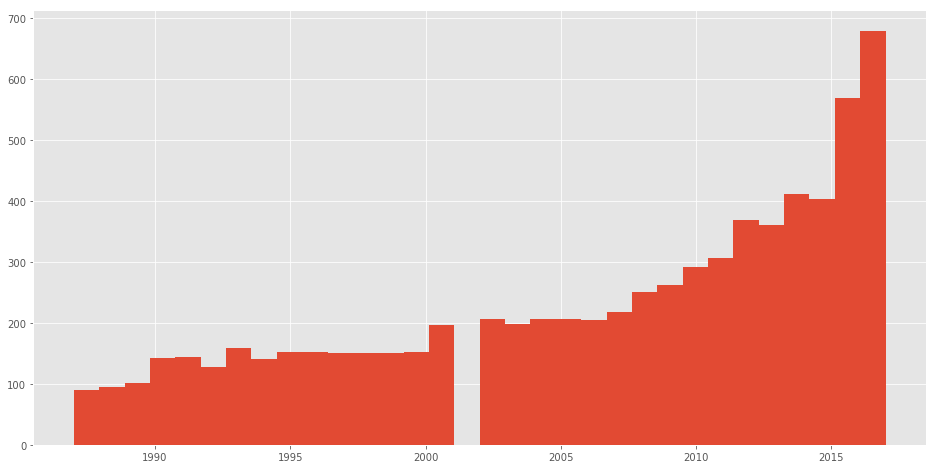

In [105]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
df_pa.year.hist(bins=32)

### Repeat for paper authors

In [122]:
# it looks like for this table, the id is auto-incremented. so it's time to define your own id
df_papauth = pd.read_csv('output/paper_authors_until2017.csv')
df_papauth['paper_id']=df_papauth['paper_id'].astype(int).astype(str)
df_papauth['author_id']=df_papauth['author_id'].astype(int).astype(str)
df_papauth['id']=df_papauth['paper_id']+df_papauth['author_id']
df_papauth = df_papauth.sort_values('id',ascending=True)
df_papauth.set_index('id', inplace=True)
df_papauth2017 = pd.read_csv('output/paper_authors_2017.csv')
df_papauth2017['paper_id']=df_papauth2017['paper_id'].astype(int).astype(str)
df_papauth2017['author_id']=df_papauth2017['author_id'].astype(int).astype(str)
df_papauth2017['id']=df_papauth2017['paper_id']+df_papauth2017['author_id']
df_papauth2017 = df_papauth2017.sort_values('id',ascending=True)
df_papauth2017.set_index('id', inplace=True)
df_papauth.shape, df_papauth2017.shape

((20838, 2), (2494, 2))

In [123]:
# in this case, the best way to combine papers is to simply merge them
df_papauthCombined = pd.merge(left=df_papauth,right=df_papauth2017,how='outer',left_index=True,right_index=True)
df_papauthCombined.shape

(20843, 4)

In [124]:
df_papauthCombined.head()

,paper_id_x,author_id_x,paper_id_y,author_id_y
id,,,,
10001229,1000,1229,NaN,NaN
1000902,1000,902,NaN,NaN
10011230,1001,1230,NaN,NaN
1001371,1001,371,NaN,NaN
100155,100,155,NaN,NaN


Looks like there's 5 new paper author combinations. So it must be a revision in the nips website since Ben has gone ahead and updated the info for 2017. I wish I had known this in advance coz the dataset reference didn't mention anything about it being updated for 2017. Additionally, the year information is present in the papers dataset which is not peek friendly. Moving on...

In [125]:
df_papauthCombined['paper_id']=np.where(pd.isnull(df_papauthCombined.paper_id_x),
                                 df_papauthCombined['paper_id_y'],df_papauthCombined['paper_id_x'])
df_papauthCombined['author_id']=np.where(pd.isnull(df_papauthCombined.author_id_x),
                                 df_papauthCombined['author_id_y'],df_papauthCombined['author_id_x'])
df_papauthCombined.drop(['paper_id_x','author_id_x','paper_id_y','author_id_y'],axis=1, inplace=True)
df_papauthCombined = df_papauthCombined.reset_index(drop=True)

In [126]:
# save to csv and json
df_papauthCombined.to_csv('output/paper_authors.csv')
df_papauthCombined.to_json('output/paper_authors.json')